## Functions for the setup ##
## NB.
During the project, we have run everything on DTU's HPC using normal python scripts as found in the git repo. However, for this notebook, we had to run it locally. 
This unfortunately means that we have not had the computational resources to run certain cells (i.e. the FID computation for the model trained on CIFAR). 

Furthermore, this notebook does not train the models for the full epochs either - e.g., we normally train the CIFAR models for 600 epochs, but here we only train a few epochs. 

Moreover, not all model configurations (i.e. all configurations of number of attention heads, noise schedule and learning rate scheduler) are also not present in this notebook as this would be very space consuming. All of our trained models are stored in a drive. 

In the last part of the notebook, we showcase some visual samples. 


In [19]:
# Imports
# import to fix issue where it crashes when run on MPS (needed because we cant run notebook on cuda)
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from torch.optim.lr_scheduler import _LRScheduler
import numpy as np
from scipy.linalg import fractional_matrix_power
import torchvision.models as models
from torchvision import transforms, datasets
import random
import torch.optim as optim
import matplotlib.pyplot as plt
import argparse
import wandb

### UNET ###
The following code block includes the Sinusoidal positional embedding framework as well as the U-net architecture.

In [21]:
### Positional Encoding ###
class SinusoidalPositionEmbeddings(nn.Module):
    '''
    From spmallick on GitHub

    - chose to use this over own implementation as it is more efficient (due to precomputing the embeddings, allowing for faster training)
    '''
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)


### SUBMODULES ###
# Block for self attention mechanism
class SelfAttentionBlock(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.0, dim_scale = 0.5):
        '''
        Attention Block with flexible dimension adjustment.

        Args:
            dim: Number of input channels.
            num_heads: Number of attention heads.
            dim_scale: Scale factor for input dimensions.
                        - Use dim_scale=0.5 for downblock.
                        - Use dim_scale=1 for upblock.
        '''
        super().__init__()
        self.scaled_dim = int(dim * dim_scale)
        self.norm = nn.LayerNorm(self.scaled_dim)
        self.mhsa = nn.MultiheadAttention(self.scaled_dim, num_heads=heads, dropout=dropout, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape

        # Reshape for multihead attention
        x_flat = x.view(B, C, -1).transpose(1, 2) # shape (B, H*W, C)

        # normalize and apply multihead attention
        x_norm = self.norm(x_flat)
        attention_out = self.mhsa(x_norm, x_norm, x_norm)[0]

        # Add residual connection
        x = x_flat + attention_out # we do this to ensure that no information from the input is lost (no matter how the attention might have changed the input)

        # Reshape back to original shape
        x = x.transpose(1, 2).view(B, C, H, W)

        return x


# Block for downsampling part of U-net
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dims, dropout=0.1, use_attention=False, heads=4):
        super().__init__()
        # First conv
        self.norm1 = nn.GroupNorm(8, in_channels)
        self.activation1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels//2, kernel_size=3, padding=1)

        # Second conv
        self.norm2 = nn.GroupNorm(8, out_channels//2)
        self.activation2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels//2, out_channels//2, kernel_size=3, padding=1)

        # Dropout, downsample, timestep embedding, and self-attention
        self.dropout = nn.Dropout2d(p=dropout)
        self.downsample = nn.Conv2d(out_channels//2, out_channels, kernel_size=3, stride=2, padding=1)
        self.time_proj = nn.Linear(time_emb_dims, out_channels//2)
        if use_attention:
            self.attention = SelfAttentionBlock(dim=out_channels, heads=heads, dim_scale=0.5)
        else:
            self.attention = nn.Identity()

    def forward(self, x, time_emb):
        # Feed time embedding through linear layer
        time_emb_proj = self.time_proj(time_emb).unsqueeze(-1).unsqueeze(-1)

        # Normalize and apply activation
        x = self.activation1(self.norm1(x))
        x = self.conv1(x)

        # Add timestep embedding
        x += self.activation1(time_emb_proj)

        # Normalize and apply activation
        x = self.activation2(self.norm2(x))
        x = self.dropout(x)
        x = self.conv2(x)

        # Apply self-attention
        x = self.attention(x)

        skip = x  # Save for skip connection
        x = self.downsample(x)
        return x, skip


# Block for bottleneck part of U-net
class BottleneckBlock(nn.Module):
    def __init__(self, channels, time_emb_dims, dropout=0.1):
        super().__init__()
        # First conv
        self.norm1 = nn.GroupNorm(8, channels)
        self.activation1 = nn.SiLU()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

        # Second conv
        self.norm2 = nn.GroupNorm(8, channels)
        self.activation2 = nn.SiLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

        self.dropout = nn.Dropout2d(p=dropout)
        self.time_proj = nn.Linear(time_emb_dims, channels)

    def forward(self, x, time_emb):
        # Feed time embedding through linear layer
        time_emb_proj = self.time_proj(time_emb).unsqueeze(-1).unsqueeze(-1)

        # Normalize and apply activation
        x = self.activation1(self.norm1(x))
        x = self.conv1(x)

        # Add timestep embedding
        x += self.activation1(time_emb_proj)

        # Normalize and apply activation
        x = self.activation2(self.norm2(x))
        x = self.dropout(x)
        x = self.conv2(x)

        return x


# Block for upsampling part of U-net
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dims, dropout=0.1, use_attention=False, heads=4):
        super().__init__()
        # First conv
        self.norm1 = nn.GroupNorm(8, in_channels)
        self.activation1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        # Second conv
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.activation2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.upsample = nn.ConvTranspose2d(out_channels*2, out_channels, kernel_size=4, stride=2, padding=1)
        self.time_proj = nn.Linear(time_emb_dims, out_channels)
        self.dropout = nn.Dropout2d(p=dropout)

        if use_attention:
            self.attention = SelfAttentionBlock(dim=out_channels, heads=heads, dim_scale=1)
        else:
            self.attention = nn.Identity()

    def forward(self, x, skip, time_emb):
        # Upsample
        x = self.upsample(x)

        # Feed time embedding through linear layer
        time_emb_proj = self.time_proj(time_emb).unsqueeze(-1).unsqueeze(-1)

        # Resize if spatial dimensions mismatch
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='nearest')

        # Add skip connection
        x = torch.cat([x, skip], dim=1)

        # Normalize and apply activation
        x = self.activation1(self.norm1(x))
        x = self.conv1(x)

        # Add timestep embedding
        x += self.activation1(time_emb_proj)

        # Normalize and apply activation
        x = self.activation2(self.norm2(x))
        x = self.dropout(x)
        x = self.conv2(x)

        # Apply self-attention
        x = self.attention(x)

        return x

### U-NET MODEL ###
class UNet(nn.Module):
    def __init__(self, input_channels=1, resolutions=[64, 128, 256, 512], time_emb_dims=512, dropout=0.1, use_attention=[False, True, False], heads=4):
        """
        U-Net implementation for DDPM
        Args:
            input_channels: Number of input channels (e.g., 1 for MNIST).
            base_channels: Number of channels in the first convolution layer.
            num_resolutions: Number of downsampling/upsampling blocks.
            time_emb_dims: Dimensionality of timestep embeddings.
        """
        super().__init__()

        self.base_channels = resolutions[0]


        # Input layer
        self.input_conv = nn.Conv2d(input_channels, self.base_channels, kernel_size=3, padding=1)

        # Downsampling blocks
        self.down_blocks = nn.ModuleList([
            DownBlock(
                in_channels=resolutions[i],
                out_channels=resolutions[i+1],
                time_emb_dims=time_emb_dims,
                dropout=dropout,
                use_attention=use_attention[i],
                heads=heads
            )
            for i in range(len(resolutions) - 1)
        ])


        # Bottleneck block
        self.bottleneck = BottleneckBlock(channels=resolutions[-1], time_emb_dims=time_emb_dims, dropout=dropout)

        # Upsampling blocks
        self.up_blocks = nn.ModuleList([
            UpBlock(
                in_channels=resolutions[i + 1],
                out_channels=resolutions[i],
                time_emb_dims=time_emb_dims,
                dropout=dropout,
                use_attention=use_attention[i],
                heads=heads
            )
            for i in reversed(range(len(resolutions) - 1))
        ])

        # Output layer
        self.output_conv = nn.Conv2d(self.base_channels, input_channels, kernel_size=3, padding=1)

    def forward(self, x, time_emb):
        """
        Forward pass of the U-Net.
        Args:
            x: Input image tensor of shape (batch_size, input_channels, height, width).
            time_emb: Timestep embedding tensor of shape (batch_size, time_emb_dims).
        Returns:
            Tensor of shape (batch_size, input_channels, height, width).
        """

        # Input conv
        x = self.input_conv(x)

        # Downsampling path
        skips = []
        for block in self.down_blocks:
            x, skip = block(x, time_emb)
            skips.append(skip)

        #print(f"Skips: {len(skips)}")
        # Bottleneck block
        x = self.bottleneck(x, time_emb)

        # Upsampling path
        for block, skip in zip(self.up_blocks, reversed(skips)):
            x = block(x, skip, time_emb)

        # Output conv
        x = self.output_conv(x)

        return x

### Diffusion Model
The DDPM setup consists of the UNET defined above, a Diffusion class implementing forward and reverse processes, a training function implementing alg. 1 and a sampling func. implementing alg. 2.

In [22]:
class Diffusion:
    def __init__(self, T=1000, beta_min=10e-5, beta_max=0.02, schedule='linear', device='cpu'):
        """
        Initialize the diffusion process.
        Args:
            T: Total number of timesteps.
            beta_min: Minimum value of beta in the noise schedule.
            beta_max: Maximum value of beta in the noise schedule.
            schedule: Type of noise schedule ('linear', 'cosine', etc.).
            device: Device to use for computations.
        """
        self.T = T
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.schedule = schedule
        self.device = device

        # Noise schedule parameters
        self.beta = None
        self.alpha = None
        self.alpha_bar = None

        # Precompute schedule
        self.get_noise_schedule()

    def get_noise_schedule(self):
        """
        Precompute the noise schedule.
        """
        if self.schedule == 'linear':
            self.beta = torch.linspace(self.beta_min, self.beta_max, self.T).to(self.device)
            self.alpha = (1 - self.beta).to(self.device)
            self.alpha_bar = self.alpha.cumprod(dim=0).to(self.device)

        elif self.schedule == 'cosine':
            steps = torch.linspace(0, torch.pi, self.T).to(self.device)
            self.beta = ((torch.cos(steps) + 1) * 0.5 * (self.beta_max - self.beta_min) + self.beta_min).flip(0)
            self.alpha = (1 - self.beta).to(self.device)
            self.alpha_bar = self.alpha.cumprod(dim=0).to(self.device)

        else:
            raise ValueError(f"Unknown schedule type: {self.schedule}")

    def forward_diffusion(self, x0, t):
        """
        Perform the forward diffusion process.
        Args:
            x0: Original data (e.g., images).
            t: Timesteps (tensor of integers).
        Returns:
            xt: Noisy data at timestep t.
            epsilon: The noise added.
        """
        eps = torch.randn_like(x0)

        sqrt_alpha_bar_t = self.alpha_bar[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = (1 - self.alpha_bar[t]).sqrt().view(-1, 1, 1, 1)

        xt = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * eps

        return xt, eps

    def reverse_diffusion(self, xt, t, model, time_embedding):
        """
        Perform the reverse diffusion process.
        Args:
            xt: Noisy data at timestep t.
            t: Timesteps for batch (tensor of integers).
            model: Model used for reverse diffusion.
            time_embedding: Time embedding object.
        Returns:
            xr: Reconstructed data at timestep t.
        """
        z = torch.where((t > 1).view(-1, 1, 1, 1), torch.randn_like(xt), torch.zeros_like(xt))

        # extract time embedding
        time_emb = time_embedding(t)

        # predict noise
        eps_theta = model(xt, time_emb)

        sqrt_alpha_t = self.alpha[t].sqrt().view(-1, 1, 1, 1)  # we need to reshape the tensor to match the shape of xt (same goes for the other tensors)
        beta_t = self.beta[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = (1 - self.alpha_bar[t]).sqrt().view(-1, 1, 1, 1)
        sigma_t = beta_t.sqrt()

        xt_minus_one = 1. / sqrt_alpha_t * (xt - (beta_t / sqrt_one_minus_alpha_bar_t) * eps_theta) + sigma_t * z

        return xt_minus_one

In [23]:
### Function for training DDPM ###
def train_ddpm_epoch(model: object, diffusion: object, time_embedding: object, train_loader: object, epoch: int, device: str, optimizer: object, lr_scheduler: object):
    """
    This function implements Algorithm 1 from the paper, specifically it trains the U-Net model for one epoch.
    Args:
        model: U-Net model.
        diffusion: Diffusion object.
        time_embedding: Time embedding object.
        train_loader: DataLoader for training data.
        epoch: Current epoch.
        device: Device to use (e.g., 'cuda' or 'cpu').
        optimizer: Optimizer for training.
    """

    print(f"Training epoch {epoch}...")

    model.train()

    for i, (x0, _) in enumerate(train_loader):
        x0 = x0.to(device)

        # Sample random timestep
        t = torch.randint(0, diffusion.T, (x0.size(0),), device=device)

        # Get sinusoidal time embedding
        time_emb = time_embedding(t)

        # Forward diffusion
        xt, epsilon = diffusion.forward_diffusion(x0, t)

        # Predict noise
        epsilon_pred = model(xt, time_emb)

        # Compute loss
        loss = F.mse_loss(epsilon_pred, epsilon)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Use learning rate scheduler
        if lr_scheduler:
            lr_scheduler.step()

        # Log loss
        wandb.log({"loss": loss.item(), "epoch": epoch, "lr": optimizer.param_groups[0]['lr']})

        if epoch > 1:
            wandb.log({"loss after 1st epoch": loss.item()})

        if i % 100 == 0:
            print(f"Epoch {epoch}, batch {i}: loss={loss.item()}")



In [5]:
### Function to sample from DDPM ###

def sample_ddpm(model: object, diffusion: object, time_embedding: object, device: str, num_samples: int = 16, dataset: str = 'MNIST'):
    """
    This function implements Algorithm 2 from the paper, specifically it samples from the U-Net model.
    Args:
        model: U-Net model.
        diffusion: Diffusion object.
        time_embedding: Time embedding object.
        device: Device to use (e.g., 'cuda' or 'cpu').
        num_samples: Number of samples to generate.
        dataset: Dataset to use ('MNIST' or 'CIFAR10').
    Returns:
        samples: Generated samples.
    """

    print(f"Sampling {num_samples} samples...")

    model.eval()
    with torch.no_grad():
        # 1. Initialize samples from standard gaussian distribution
        if dataset == 'MNIST':
            x = torch.randn((num_samples, 1, 28, 28), device=device)
        elif dataset == 'CIFAR10':
            x = torch.randn((num_samples, 3, 32, 32), device=device)

        # 2. iterative reverse diffusion
        for t in reversed(range(1, diffusion.T + 1)):
            # prepare timestep tensor
            t_tensor = torch.full((num_samples,), t - 1, device=device, dtype=torch.long)

            # Perform reverse diffusion step
            x = diffusion.reverse_diffusion(x, t_tensor, model, time_embedding)

        # 3. Return samples
        return x

### Helper functions

In [24]:
### Dataloader ###
def get_dataloader(dataset = "MNIST", batch_size = 128):
    transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                # No flips in MNIST as it disturbes the interpretation of numbers?
                #torchvision.transforms.Resize((32, 32), interpolation=torchvision.transforms.InterpolationMode.BICUBIC), # TODO: Resize to 32 x 32 for unet implementation?
                torchvision.transforms.Normalize((0.5,), (0.5,))  # Correpsonds to scaling between [-1, 1] --> (x - 0.5)/0.5
            ]
        )

    transforms_cifar10_train = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.RandomHorizontalFlip(),
                #torchvision.transforms.Resize((32, 32), interpolation=torchvision.transforms.InterpolationMode.BICUBIC), # TODO: Match paper or resize to 28 x 28 for unet implementation
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Scaling between [-1, 1]
            ]
        )

    transforms_cifar10_test = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                #torchvision.transforms.Resize((32, 32), interpolation=torchvision.transforms.InterpolationMode.BICUBIC), # TODO: Match paper or resize to 28 x 28 for unet implementation
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Scaling between [-1, 1]
            ]
        )
    if dataset == "MNIST":
        trainset = MNIST("./temp/", train=True, download=True, transform= transforms)
        testset = MNIST("./temp/", train=False, download=True, transform= transforms)
    elif dataset == "CIFAR10":
        trainset = CIFAR10("./temp/", train=True, download=True, transform= transforms_cifar10_train)
        testset = CIFAR10("./temp/", train=False, download=True, transform= transforms_cifar10_test)


    train_dataloader = DataLoader(trainset, batch_size=batch_size, num_workers=0, shuffle=True)
    test_dataloader = DataLoader(testset, batch_size=batch_size, num_workers=0, shuffle=True)
    return train_dataloader, test_dataloader


def get_dataloader_evaluation(dataset = "MNIST", batch_size = 128):
    transforms_mnist = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
            torchvision.transforms.Resize((299, 299)),  # Resize for InceptionV3
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #normalize for InceptionV3
        ]
    )

    transforms_cifar10 = torchvision.transforms.Compose(
          [
              torchvision.transforms.Resize((299, 299)),  # Resize for InceptionV3
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # CIFAR normalization
          ])


    if dataset == "MNIST":
        trainset = MNIST("./temp/", train=True, download=True, transform= transforms_mnist)
    elif dataset == "CIFAR10":
        trainset = CIFAR10("./temp/", train=True, download=True, transform= transforms_cifar10)


    train_dataloader = DataLoader(trainset, batch_size=batch_size, num_workers=0, shuffle=True)
    return train_dataloader

### Custom learning rate scheduler

In [25]:
### Custom Learning Rate Scheduler ###
class WarmUpPiecewiseConstantSchedule(_LRScheduler):
    '''
    This class implements a learning rate scheduler that combines a warm-up phase with a piecewise constant decay.
    That is, the learning rate is increased linearly from 0 to the base learning rate during the warm-up phase, and then
    decreased by a factor of decay_ratio at each epoch in decay_epochs (similarly to MultiStepLR).
    Note: can maybe be done better, but needed it done quickly...

    Note: I implemented this class as part of my bachelor's thesis (jonathansim).
    '''
    def __init__(self, optimizer, steps_per_epoch, base_lr, lr_decay_ratio, lr_decay_epochs, warmup_epochs, last_epoch=-1):
        self.steps_per_epoch = steps_per_epoch
        self.base_lr = base_lr
        self.decay_ratio = lr_decay_ratio
        self.decay_epochs = lr_decay_epochs
        self.warmup_epochs = warmup_epochs
        self.decay_steps = [e * steps_per_epoch for e in lr_decay_epochs]  # Convert epochs to steps
        super(WarmUpPiecewiseConstantSchedule, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # Calculate the current step
        lr_step = self.last_epoch
        lr_epoch = lr_step / self.steps_per_epoch
        learning_rate = self.base_lr

        # Warm-Up Phase
        if lr_epoch < self.warmup_epochs:
            learning_rate = self.base_lr * lr_step / (self.warmup_epochs * self.steps_per_epoch)
        else:
            # Piecewise Constant Decay Phase
            for i, start_step in enumerate(self.decay_steps):
                if lr_step >= start_step:
                    learning_rate = self.base_lr * (self.decay_ratio ** (i + 1))
                else:
                    break

        return [learning_rate for _ in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [8]:
### Function for setting seed ###
def set_training_seed(seed):
    # Function to set the different seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

### Evaluation functions ###

In [26]:
### Frechet Inception Distance ###
def calculate_fid(feat1, feat2):
    '''
    calculate fid between two sets of images
    feat1: real images - feature vector obtained from inception model (or alternative model)
    feat2: generated images - feature vector obtained from inception model (or alternative model)
    return: fid score
    '''
    # calculate mean and covariance of features
    mu1, sigma1 = np.mean(feat1, axis=0), np.cov(feat1, rowvar=False)
    mu2, sigma2 = np.mean(feat2, axis=0), np.cov(feat2, rowvar=False)
    print("Mean1: ", np.shape(mu1))
    print("Mean2: ", np.shape(mu2))
    # sum squared difference between means
    diff = np.sum((mu1 - mu2)**2)
    print("diff: ", diff)
    # calculate "geometric mean" of covariance matrices
    covmean = fractional_matrix_power(sigma1.dot(sigma2), 0.5)
    # check for imaginary numbers
    if np.iscomplexobj(covmean):
        covmean = np.real(covmean)

    fid = diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


def compute_activations(samples, model, batched = False, batch_size = 100):
    """
    Compute activations from samples based on model.
    Args:
        samples: Tensor of shape (num_samples, channels, height, width)
        model: Pre-trained model to extract features
    Returns:
        activations: Feature activations for input images
    """
    model.eval()
    samples = samples.to(next(model.parameters()).device)  # Move to the same device as the model

    if batched:
        activations = []
        with torch.no_grad():
            for i in range(0, samples.size(0), batch_size):
                batch = samples[i:i+batch_size]
                batch_activations = model(batch).cpu().numpy()
                activations.append(batch_activations)
        return np.concatenate(activations, axis=0)
    else:
        with torch.no_grad():
            activations = model(samples)
        return activations.cpu().numpy()


def get_images_in_batches(dataloader, num_images=None):
    """
    Fetch e.g. CIFAR-10 images in smaller batches without concatenating them.
    Args:
        dataloader: PyTorch DataLoader providing the dataset.
        num_images: Number of images to fetch.
    Yields:
        Batches of real images from the dataset.
    """
    count = 0
    for images, _ in dataloader:
        count += len(images)
        if num_images and count >= num_images:
            yield images
            break

        # Yield images batch-by-batch
        yield images

        # Free memory
        del images
        torch.cuda.empty_cache()


def full_fid(generated_samples, data, num_images = 10000):
    """
    Computes the Fréchet Inception Distance (FID) between generated images and real images.
    Args:
        generated_samples (torch.Tensor): Tensor of generated samples
            with shape (num_samples, channels, height, width).
        data (str): MNIST or CIFAR10
        num_images (int, optional): Number of real images to use for FID computation.
            Defaults to 10,000.
    Returns:
        float: FID score between the generated and real images.
    """

    # Load pre-trained InceptionV3
    device = torch.device("cuda" if torch.cuda.is_available() else
                    "mps" if torch.backends.mps.is_available() else
                    "cpu")
    
    # PYTORCH_ENABLE_MPS_FALLBACK=1 # set environment to enable to fallback to cpu
    inception_classifier = models.inception_v3(weights='DEFAULT', transform_input=False)
    inception_classifier.fc = torch.nn.Identity()  # remove classification layer to extract features
    inception_classifier = inception_classifier.to(device)

    # Get train samples
    dataloader = get_dataloader_evaluation(dataset = data, batch_size = 100)
    print("DATA: ", data)
    # Get activations for real images
    real_image_activations = []
    for batch in get_images_in_batches(dataloader, num_images=num_images):
        activation = compute_activations(batch, inception_classifier)
        real_image_activations.extend(activation)
    real_image_activations = real_image_activations[:num_images]

    # Get activations of generated images
    min_val = generated_samples.min()
    max_val = generated_samples.max()
    resized_samples = (generated_samples - min_val) / (max_val - min_val) # rescale pixel values to [0,1]
    if data == "MNIST":
        resized_samples = resized_samples.repeat(1, 3, 1, 1)
    resized_samples = torchvision.transforms.functional.resize(resized_samples, size = (299, 299)) # resize for inception
    resized_samples = torchvision.transforms.functional.normalize(resized_samples,
        mean=torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1).to(device),
        std=torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1).to(device)
    )
    generated_image_activations = compute_activations(resized_samples, inception_classifier, batched = True)
    print(np.shape(generated_image_activations))
    print(np.shape(real_image_activations))
    fid = calculate_fid(real_image_activations, generated_image_activations)

    return fid

# full_fid splitted up
def get_inception_model():
    device = torch.device("cuda" if torch.cuda.is_available() else
                    "mps" if torch.backends.mps.is_available() else
                    "cpu")
    inception_classifier = models.inception_v3(weights='DEFAULT', transform_input=False)
    inception_classifier.fc = torch.nn.Identity()  # remove classification layer to extract features
    inception_classifier = inception_classifier.to(device)
    return inception_classifier


def get_real_image_activations(inception_classifier, data, num_images = 10000):
    # Get train samples
    dataloader = get_dataloader_evaluation(dataset = data, batch_size = 100)
    print("DATA: ", data)
    # Get activations for real images
    real_image_activations = []
    for batch in get_images_in_batches(dataloader, num_images=num_images):
        activation = compute_activations(batch, inception_classifier)
        real_image_activations.extend(activation)
    real_image_activations = real_image_activations[:num_images]
    return real_image_activations


def calculate_fid_generated_samples(generated_samples, real_image_activations, inception_classifier, device, data, num_images = 10000):
    # Get activations of generated images
    min_val = generated_samples.min()
    max_val = generated_samples.max()
    resized_samples = (generated_samples - min_val) / (max_val - min_val) # rescale pixel values to [0,1]
    if data == "MNIST":
        resized_samples = resized_samples.repeat(1, 3, 1, 1)
    resized_samples = torchvision.transforms.functional.resize(resized_samples, size = (299, 299)) # resize for inception
    resized_samples = torchvision.transforms.functional.normalize(resized_samples,
        mean=torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1).to(device),
        std=torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1).to(device)
    )
    generated_image_activations = compute_activations(resized_samples, inception_classifier, batched = True)
    print(np.shape(generated_image_activations))
    print(np.shape(real_image_activations))
    fid = calculate_fid(real_image_activations, generated_image_activations)
    return fid

In [27]:
### Inception Score ###
def calculate_inception_score(samples, dataset, device, batch_size=32, splits=10):
    """
    Calculates the Inception Score for generated samples.
    Inspired by: https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py
    and paper: https://papers.nips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf

    Args:
        samples (torch.Tensor): Generated samples with shape (num_samples, channels, height, width).
        device (torch.device): Device to perform calculations on
        dataset (str): One of the two datasets
        batch_size (int): Batch size for processing samples.
        splits (int): Number of splits for calculating the mean and standard deviation of the score.

    Returns:
        float, float: Mean and standard deviation of the Inception Score.
    """

    # Load pretrained InceptionV3 model
    inception_model = models.inception_v3(pretrained=True)  # keep the final classification layer
    inception_model = inception_model.to(device)

    inception_model.eval()
    samples = samples.to(device)
    num_samples = samples.size(0)

    # Placeholder for storing predictions
    preds = []

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch = samples[i:i + batch_size]
            if dataset == "MNIST":
                batch = batch.repeat(1, 3, 1, 1)  # repeat channels for Inception when using MNIST
            batch = transforms.functional.resize(batch, size=(299, 299))  # resize for Inception
            batch = transforms.functional.normalize(batch,
                mean=torch.tensor([0.485, 0.456, 0.406]).to(device),
                std=torch.tensor([0.229, 0.224, 0.225]).to(device),
            )
            pred = inception_model(batch)
            pred = F.softmax(pred, dim=1)
            preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Compute IS
    scores = []
    split_size = preds.shape[0] // splits
    for i in range(splits):
        part = preds[i * split_size: (i + 1) * split_size] # probability of labels conditioned on image
        p_y = np.mean(part, axis=0)
        kl_div = part * (np.log(part) - np.log(p_y[None, :]))
        kl_div = np.sum(kl_div, axis=1)
        scores.append(np.exp(np.mean(kl_div)))

    return np.mean(scores), np.std(scores)

## Training of Models ##
Since we run various experiments with two different datasets MNIST and CIFAR10 and different parameters, we made a general pipeline for training and evaluating our models:

In [28]:
### Main training script ###

## Argument parser
parser = argparse.ArgumentParser(description='Train (and sample from) DDPM framework.')

## Add arguments
parser.add_argument('--T', type=int, default=1000, help='Total timesteps.')
parser.add_argument('--batch_size', type=int, default=128, help='Batch size.')
parser.add_argument('--num_epochs', type=int, default=5, help='Number of epochs.')
parser.add_argument('--lr', type=float, default=2e-4, help='Learning rate.')
parser.add_argument('--dataset', type=str, default='MNIST', help='Dataset to use (MNIST or CIFAR10).')
parser.add_argument('--save_model', type=bool, default=True, help='Save model after training.')
parser.add_argument('--wandb', default="online", type=str, choices=["online", "disabled"] , help="whether to track with weights and biases or not")
parser.add_argument('--heads', type=int, default=4, help='Number of heads for attention mechanism.')
parser.add_argument('--noise_scheduler', type=str, default='cosine', choices=["linear", "cosine"], help='Noise scheduler type.')
parser.add_argument('--lr_scheduler', type=str, default='none', choices=["none", "warmup_linear"], help='Learning rate scheduler type.')
parser.add_argument('--seed', default=1, type=int, help="seed for reproducibility")
parser.add_argument('--fid', default=True, type=bool, help="Calculate FID for 10000 images after training")
parser.add_argument('--calculate_fid_25', default=True, type=bool, help="Calculate FID for 2500 images after every fid_epoch_modulo (e.g. 25th) epoch")
parser.add_argument('--fid_epoch_modulo', default=50, type=int, help="Which epochs to run fid")


def main(args):
    # Parse arguments
    #args = parser.parse_args()
    args = args # Redefine argument parsing when running in notebook

    # Set seed for reproducibility
    set_training_seed(args.seed)

    # Unpack arguments
    T = args.T
    batch_size = args.batch_size
    num_epochs = args.num_epochs
    lr = args.lr
    dataset = args.dataset
    save_model = args.save_model
    heads = args.heads
    noise_scheduler = args.noise_scheduler
    lr_scheduler = args.lr_scheduler
    calculate_fid = args.fid
    calculate_fid_25 = args.calculate_fid_25
    fid_epoch_modulo = args.fid_epoch_modulo


    # Scheduler parameters
    warm_up_epochs = 2
    if dataset == 'MNIST':
        lr_decay_epochs = [20, 40, 60]
    elif dataset == 'CIFAR10':
        lr_decay_epochs = [200, 400, 500]


    save_dir = "./saved_models"  # Directory to save the trained model

    # Set number of input channels
    num_input_channels = 1 if dataset == 'MNIST' else 3

    # Set mode for Weights and Biases
    mode_for_wandb = args.wandb
    run_name = f"{dataset}_bs_{batch_size}_Nscheduler_{noise_scheduler}_heads_{heads}_LRs_{lr_scheduler}_seed_{args.seed}"

    # Initialize Weights and Biases
    wandb.init(project='ddpm', entity='dl_ddpm', mode=mode_for_wandb, name=run_name)

    device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else
                      "cpu")
    print(f"Using Device: {device}")

    # Dataloader
    train_loader, _ = get_dataloader(dataset, batch_size=batch_size)

    # Initialize components
    diffusion = Diffusion(T=T, beta_min=10e-5, beta_max=0.02, schedule=noise_scheduler, device=device)

    time_embedding = SinusoidalPositionEmbeddings(total_time_steps=T, time_emb_dims=128, time_emb_dims_exp=512).to(device)

    model = UNet(input_channels=num_input_channels,
                 resolutions=[64, 128, 256, 512],
                 time_emb_dims=512,
                 dropout=0.1,
                 use_attention=[False, True, False],
                 heads=heads).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    if lr_scheduler == "warmup_linear":
        scheduler = WarmUpPiecewiseConstantSchedule(optimizer=optimizer, steps_per_epoch=len(train_loader), base_lr=args.lr,
                                                    lr_decay_ratio=0.2, lr_decay_epochs=lr_decay_epochs, warmup_epochs=warm_up_epochs)
    else:
        scheduler = None


    # Training loop
    if calculate_fid_25:
        inception_model = get_inception_model()
        real_activations = get_real_image_activations(inception_classifier=inception_model, data=dataset, num_images=2500)
    fid_epochs = []
    for epoch in range(1, num_epochs + 1):
        train_ddpm_epoch(model, diffusion, time_embedding, train_loader, epoch, device, optimizer, scheduler)

        if epoch % 5 == 0:
            # Generate samples
            samples = sample_ddpm(model, diffusion, time_embedding, device, num_samples=2, dataset=dataset)
            wandb.log({"Generated Samples": [wandb.Image(sample, caption=f"Epoch {epoch}") for sample in samples]})

        if calculate_fid_25:
            if epoch == 1:
                samples = sample_ddpm(model, diffusion, time_embedding, device, num_samples=2500, dataset=dataset)
                fid_epochs.append(calculate_fid_generated_samples(generated_samples=samples,
                                                                  real_image_activations=real_activations,
                                                                  inception_classifier=inception_model,
                                                                  data = dataset,
                                                                  num_images = 2500,
                                                                  device = device))
                wandb.log({"FID": fid_epochs[-1]})
            if epoch % fid_epoch_modulo == 0:
                samples = sample_ddpm(model, diffusion, time_embedding, device, num_samples=2500, dataset=dataset)
                fid_epochs.append(calculate_fid_generated_samples(generated_samples=samples,
                                                                  real_image_activations=real_activations,
                                                                  inception_classifier=inception_model,
                                                                  data = dataset,
                                                                  num_images = 2500,
                                                                  device = device))
                wandb.log({"FID": fid_epochs[-1]})
    print("FID_epochs: ", fid_epochs)
    if save_model:
        final_save_path = f"{save_dir}/ddpm_{dataset}_{noise_scheduler}_heads_{heads}_LRs_{lr_scheduler}_seed{args.seed}.pth"
        torch.save({
            'model_state_dict': model.state_dict(),
            "embedding_state_dict": time_embedding.state_dict(),
        }, final_save_path)

        print(f"Model and embedding saved at: {final_save_path}")

    if calculate_fid:
        # Calculate FID
        samples = sample_ddpm(model, diffusion, time_embedding, device, num_samples=10000, dataset=dataset)
        print("Samples generated successfully!")
        print("Shape samples: ", np.shape(samples))

        fid = full_fid(samples, data = dataset, num_images = 10000)
        wandb.log({"full_FID": fid})
        print("Fid: ", fid)
        # Finish Weights and Biases run
        wandb.finish()

## Examples using the script
Since it is not feasible to run all our experiments in a notebook we provide a small example of how our setup runs. In reality we ran the main script with different arguments corresponding to our specific experiments.
1) An example of MNIST - we only train for 5 epochs in our real experiments we run 75
2) An example of CIFAR10 - we only train for 5 epochs in the notebook, but in our real experiments we run 600 epochs
3) An example of FID and IS calculation based on a saved model - In our experiments we sample 10K generated images, but here we only sample 2500

In [12]:
### MNIST Example ###
from types import SimpleNamespace
import sys
args = SimpleNamespace(
    T=1000,
    batch_size=128,
    num_epochs=5, #normally 75
    lr=2e-4,
    dataset="MNIST",
    save_model=False,
    wandb="disabled",
    heads=1, # This is changed for the different models
    noise_scheduler="linear", # This is changed to "cosine" for models using a cosine noise schedule
    lr_scheduler="none", # This is changed to "warmup_linear" when using the custom lr_scheduler
    seed=1,
    fid=False,
    calculate_fid_25=False,
    fid_epoch_modulo=50
)

main(args)


Using Device: cuda
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]


Extracting ./temp/MNIST/raw/train-images-idx3-ubyte.gz to ./temp/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]


Extracting ./temp/MNIST/raw/train-labels-idx1-ubyte.gz to ./temp/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.77MB/s]


Extracting ./temp/MNIST/raw/t10k-images-idx3-ubyte.gz to ./temp/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.91MB/s]


Extracting ./temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./temp/MNIST/raw

Training epoch 1...
Epoch 1, batch 0: loss=1.0248407125473022
Epoch 1, batch 100: loss=0.09949691593647003
Epoch 1, batch 200: loss=0.06893058121204376
Epoch 1, batch 300: loss=0.04778468608856201
Epoch 1, batch 400: loss=0.05255862697958946
Training epoch 2...
Epoch 2, batch 0: loss=0.05860847234725952
Epoch 2, batch 100: loss=0.03983432799577713
Epoch 2, batch 200: loss=0.035100847482681274
Epoch 2, batch 300: loss=0.04526690021157265
Epoch 2, batch 400: loss=0.03606978803873062
Training epoch 3...
Epoch 3, batch 0: loss=0.03434152528643608
Epoch 3, batch 100: loss=0.032479044049978256
Epoch 3, batch 200: loss=0.04145487770438194
Epoch 3, batch 300: loss=0.03720972314476967
Epoch 3, batch 400: loss=0.029410317540168762
Training epoch 4...
Epoch 4, batch 0: loss=0.0346800722181797
Epoch 4, batch 100: loss=0.032416850328445435
Epoch 4, batch 200: loss=0.03310177102684975
Epoch 4, batch 300: loss=0.03253283351659

In [13]:
### CIFAR10 Example ###
args = SimpleNamespace(
    T=1000,
    batch_size=128,
    num_epochs=5, # Normally 600
    lr=2e-4,
    dataset="CIFAR10",
    save_model=False,
    wandb="disabled",
    heads=1,
    noise_scheduler="linear",
    lr_scheduler="none",
    seed=1,
    fid=False,
    calculate_fid_25=False,
    fid_epoch_modulo=50
)

main(args)


Using Device: cuda


100%|██████████| 170M/170M [00:05<00:00, 30.0MB/s]


Extracting ./temp/cifar-10-python.tar.gz to ./temp/
Files already downloaded and verified
Training epoch 1...
Epoch 1, batch 0: loss=1.0528299808502197
Epoch 1, batch 100: loss=0.15049698948860168
Epoch 1, batch 200: loss=0.10594990104436874
Epoch 1, batch 300: loss=0.08235377073287964
Training epoch 2...
Epoch 2, batch 0: loss=0.07530054450035095
Epoch 2, batch 100: loss=0.08824054896831512
Epoch 2, batch 200: loss=0.07016375660896301
Epoch 2, batch 300: loss=0.06308020651340485
Training epoch 3...
Epoch 3, batch 0: loss=0.06016600877046585
Epoch 3, batch 100: loss=0.04957980662584305
Epoch 3, batch 200: loss=0.06536881625652313
Epoch 3, batch 300: loss=0.05608316510915756
Training epoch 4...
Epoch 4, batch 0: loss=0.05260009691119194
Epoch 4, batch 100: loss=0.05747954174876213
Epoch 4, batch 200: loss=0.05371551960706711
Epoch 4, batch 300: loss=0.06030559539794922
Training epoch 5...
Epoch 5, batch 0: loss=0.0474037230014801
Epoch 5, batch 100: loss=0.0632072240114212
Epoch 5, batc

In [ ]:
### Example of FID + IS for trained CIFAR model ###
## N.B. 
# When trying to compute the FID on GPU, this consistently crashes and we have unfortunately not been able to solve this issue. 
# We hope showcasing the code with an example where the FID is calculated on CPU (with much fewer samples) will be sufficient.

set_training_seed(7)

# device = torch.device("cuda" if torch.cuda.is_available() else
                    #"mps" if torch.backends.mps.is_available() else
                    # "cpu")
device = torch.device("cpu")
print(f"Using Device: {device}")

# Step 1: Initialize the Sinusoidal Embeddings
time_embedding = SinusoidalPositionEmbeddings(total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512).to(device)

# Step 2: Initialize the U-Net and Diffusion
unet = UNet(input_channels=3, resolutions=[64, 128, 256, 512], time_emb_dims=512, dropout=0.1, use_attention=[False, True, False], heads=4).to(device)
diffusion = Diffusion(T=1000, beta_min=10e-5, beta_max=0.02, schedule='cosine', device=device)

# Step 3: Load the trained model
model_path = "trained_models/ddpm_CIFAR10_cosine_heads_4_LRs_warmup_linear_seed7.pth" # insert model path for model we wish to evaluate
print("Model_path: ", model_path)
saved = torch.load(model_path, map_location=device)

unet.load_state_dict(saved["model_state_dict"])
time_embedding.load_state_dict(saved["embedding_state_dict"])


# Step 4: Generate samples
samples = sample_ddpm(unet, diffusion, time_embedding, device, num_samples=50, dataset='CIFAR10') # usually 10K images, but here lowered for faster calculation
print("Samples generated successfully!")

PYTORCH_ENABLE_MPS_FALLBACK=1 
fid = full_fid(samples, data = "CIFAR10", num_images = 50) # usually 10K images, but here lowered for faster calculation
print("Fid: ", fid)

# Calculate Inception Score
mean_is, std_is = calculate_inception_score(samples, "CIFAR10", device)
print(f"Inception Score: {mean_is}")

Using Device: cpu
Model_path:  trained_models/ddpm_CIFAR10_cosine_heads_4_LRs_warmup_linear_seed7.pth
Sampling 50 samples...


/var/folders/sb/klhtpy1n7jd649__g8r7xj300000gn/T/ipykernel_62026/4234486406.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model_path, map_location=

Samples generated successfully!
Files already downloaded and verified
DATA:  CIFAR10
(50, 2048)
(50, 2048)
Mean1:  (2048,)
Mean2:  (2048,)
diff:  15.942528
Fid:  221.8422500873504
Inception Score: 2.5218093395233154


### Baselines

In [33]:
def compute_pixel_distribution(dataloader):
    """
    Compute mean and std for each pixel position in the dataset.
    Args:
        dataloader: DataLoader containing the dataset.
    Returns:
        mean: Pixel-wise mean
        std: Pixel-wise std
    """
    pixel_sum = 0
    pixel_sum_squared = 0
    num_samples = 0

    for images, _ in dataloader:
        pixel_sum += images.sum(dim=0)  # Sum across batch
        pixel_sum_squared += (images ** 2).sum(dim=0)
        num_samples += images.size(0)  # Number of samples in batch

    mean = pixel_sum / num_samples
    std = torch.sqrt(pixel_sum_squared / num_samples - mean ** 2)
    return mean, std

def generate_images(mean, std, num_images=10):
    """
    Generate images by sampling from the learned distribution.
    Args:
        mean: Pixel-wise mean (height, width) or (channels, height, width).
        std: Pixel-wise std deviation (same shape as mean).
        num_images: Number of images to generate.
    Returns:
        Tensor of generated images.
    """
    return torch.normal(mean=mean, std=std).unsqueeze(0).repeat(num_images, 1, 1, 1)

# make new dataloaders without DDPM specific transforms
def get_mnist_dataloader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.MNIST(root="./temp", train=True, download=True, transform=transform)
    return DataLoader(trainset, batch_size=batch_size, shuffle=True)

def get_cifar10_dataloader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.CIFAR10(root="./temp", train=True, download=True, transform=transform)
    return DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [16]:
### Example for MNIST ###
set_training_seed(7)

device = torch.device("cuda" if torch.cuda.is_available() else
                    "mps" if torch.backends.mps.is_available() else
                    "cpu")
print(f"Using Device: {device}")

# MNIST MPM ("Upper Bound") (again only evaluated with 2.5K images instead of 10K)
data = "MNIST"
batch_size = 128
print("MPM: ")
dataloader = get_mnist_dataloader(batch_size=batch_size)
mean, std = compute_pixel_distribution(dataloader)
generated_images = generate_images(mean, std, num_images=2500)
generated_images = generated_images.to(device)
fid = full_fid(generated_samples=generated_images, data=data, num_images = 2500)
print("Fid: ", fid)

# MNIST REAL ("Lower Bound") (again only evaluated with 2.5K images instead of 10K)
print("REAL:")
inception_model = get_inception_model()
real_activations = get_real_image_activations(inception_classifier=inception_model, data=data, num_images=5000)
fid = calculate_fid(real_activations[:2500], real_activations[2500:])
print("Fid: ", fid)


Using Device: cuda
MPM: 


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 162MB/s] 


DATA:  MNIST
(2500, 2048)
(2500, 2048)
Mean1:  (2048,)
Mean2:  (2048,)
diff:  311.23703
Fid:  421.49151427009207
REAL:
DATA:  MNIST
Mean1:  (2048,)
Mean2:  (2048,)
diff:  0.08329368
Fid:  4.9017019593237485


In [ ]:
### DCGAN baseline fro CIFAR10 ###
from dcgan_cifar import Discriminator, Generator

num_gpu = 1 if torch.cuda.is_available() else 0

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

D.load_state_dict(torch.load('netD_epoch_199.pth'))
G.load_state_dict(torch.load('netG_epoch_199.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()


def generate_fake_images(generator, num_samples=10000, latent_dim=100, device=device):
    generator.eval()
    z = torch.randn(num_samples, latent_dim, 1, 1, device=device)  # Random noise
    with torch.no_grad():
        fake_images = generator(z)  # Shape: [num_samples, 1, 28, 28]
    return fake_images



gen_img = generate_fake_images(G, num_samples=10000, latent_dim=100, device=device)
print(np.shape(gen_img))
print("MODEL: DC GAN")
fid = full_fid(gen_img, data="CIFAR10" ,num_images=10000)
print("FID:", fid)

mean_is, std_is = calculate_inception_score(samples=gen_img, dataset='CIFAR10', device=device, batch_size=32, splits=10)
print("IS: ", mean_is)


## Visualized samples 
The below shows the functions we used to visualize the samples drawn, with an example shown where we sample and visualize 28 MNIST images. 

In [34]:
def visualize_samples_cifar10(samples, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), num_cols=math.ceil(math.sqrt(25))): 
    """
    Visualize the generated samples in multiple rows.
    Args:
        samples: Generated samples of shape (num_samples, 3, 32, 32).
        mean: Tuple of mean values used for normalization (default for CIFAR is (0.5, 0.5, 0.5)).
        std: Tuple of std values used for normalization (default for CIFAR is (0.5, 0.5, 0.5)).
        num_cols: Number of images per row.
    """
    # Denormalize the images
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(samples.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(samples.device)
    samples = samples * std + mean  # Denormalize

    # Clip values to [0, 1] range for display
    samples = samples.clamp(0, 1)

    num_samples = samples.size(0)
    num_rows = math.ceil(num_samples / num_cols)  # Calculate the number of rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

    # Flatten axs array for easier iteration, even if it's a single row
    axs = axs.flatten()

    for i in range(num_samples):
        sample = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert (3, 32, 32) -> (32, 32, 3)
        axs[i].imshow(sample)
        axs[i].axis('off')

    # Turn off axes for unused subplots
    for j in range(num_samples, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


def visualize_samples_mnist(samples, mean=(0.5), std=(0.5), num_cols=math.ceil(math.sqrt(25))): 
    """
    Visualize the generated samples in multiple rows.
    Args:
        samples: Generated samples of shape (num_samples, 3, 32, 32).
        mean: Tuple of mean values used for normalization (default for CIFAR is (0.5, 0.5, 0.5)).
        std: Tuple of std values used for normalization (default for CIFAR is (0.5, 0.5, 0.5)).
        num_cols: Number of images per row.
    """
    # Denormalize the images
    mean = torch.tensor(mean).view(1, 1, 1, 1).to(samples.device)
    std = torch.tensor(std).view(1, 1, 1, 1).to(samples.device)
    samples = samples * std + mean  # Denormalize

    # Clip values to [0, 1] range for display
    samples = samples.clamp(0, 1)

    num_samples = samples.size(0)
    num_rows = math.ceil(num_samples / num_cols)  # Calculate the number of rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

    # Flatten axs array for easier iteration, even if it's a single row
    axs = axs.flatten()

    for i in range(num_samples):
        sample = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert (3, 32, 32) -> (32, 32, 3)
        axs[i].imshow(sample, cmap='gray')
        axs[i].axis('off')

    # Turn off axes for unused subplots
    for j in range(num_samples, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

Using Device: mps


/var/folders/sb/klhtpy1n7jd649__g8r7xj300000gn/T/ipykernel_62026/3187388759.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model_path, map_location=

Total parameters: 13756929
Trainable parameters: 13756929
Sampling 28 samples...
Samples generated successfully!


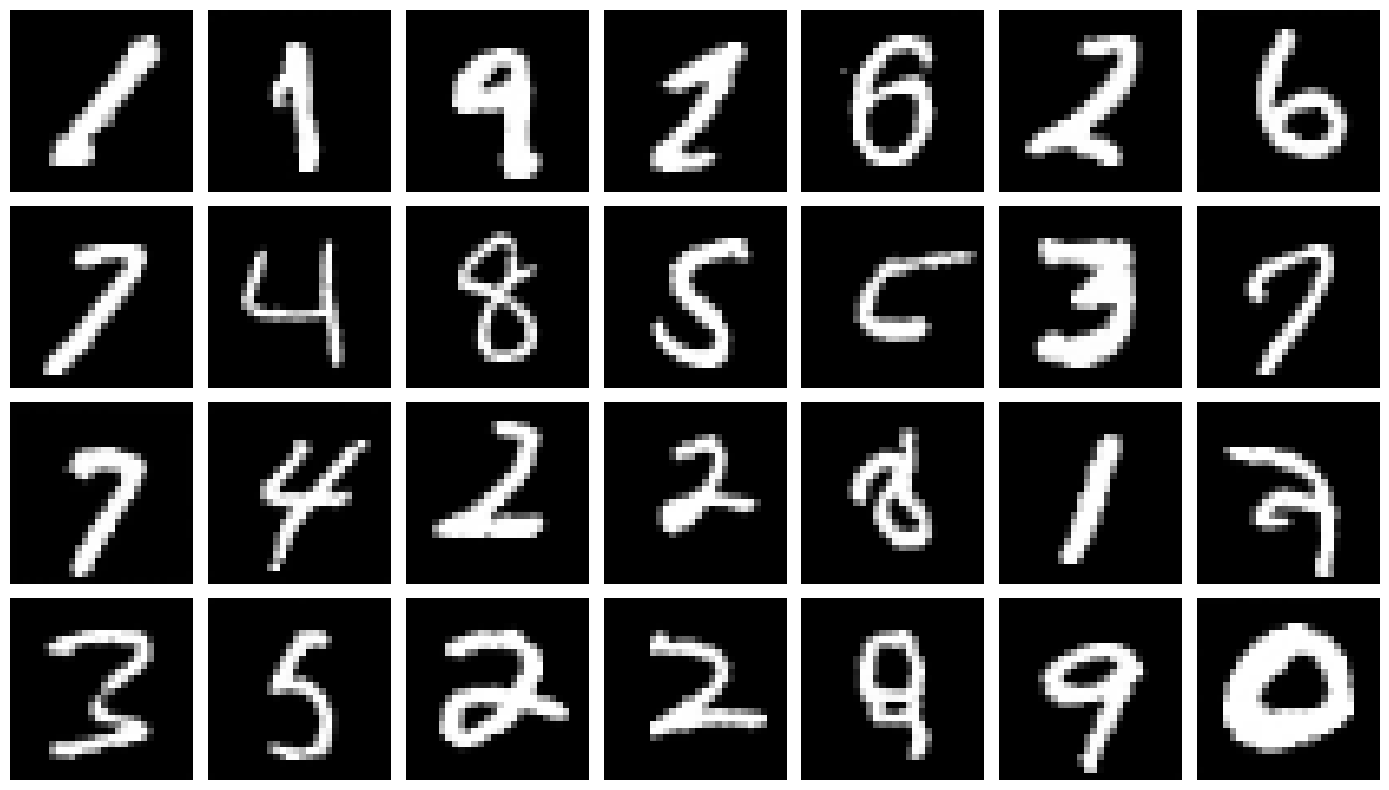

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print(f"Using Device: {device}")

# Step 1: Initialize the Sinusoidal Embeddings
time_embedding = SinusoidalPositionEmbeddings(total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512).to(device)

# Step 2: Initialize the U-Net and Diffusion
unet = UNet(input_channels=1, resolutions=[64, 128, 256, 512], time_emb_dims=512, dropout=0.1, use_attention=[False, True, False], heads=4).to(device)
diffusion = Diffusion(T=1000, beta_min=10e-5, beta_max=0.02, schedule='cosine', device=device)

# Step 3: Load the trained model
#model_path = "ddpm_CIFAR10_linear_heads_1_LRs_none_seed7.pth"
model_path = "trained_models/ddpm_MNIST_cosine_final.pth"
saved = torch.load(model_path, map_location=device)

unet.load_state_dict(saved["model_state_dict"])
time_embedding.load_state_dict(saved["embedding_state_dict"])

# Number of params (TEST)
total_params = sum(p.numel() for p in unet.parameters())
trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Step 4: Generate samples
samples = sample_ddpm(unet, diffusion, time_embedding, device, num_samples=28, dataset='MNIST')
print("Samples generated successfully!")
#visualize_samples_cifar10(samples, num_cols=8)
visualize_samples_mnist(samples, num_cols=7)


See plots_for_report notebook for further plots used in the report, such as the FID-during-training plots etc. 